In [1]:
import sys
sys.path.append('../src') # hack to add the source code directory!
from ContinuumExcitableElasticity import pde, ContourPlotAnimator
from pde import CartesianGrid,UnitGrid, Controller, MemoryStorage, ScalarField, FieldCollection, PlotTracker, ExplicitSolver,VectorField
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook
import sys,time

In [2]:
# Simulation parameters
# Physical Box Size
L=20
# number of points, its easier to do the math if this is odd
Npts=51
#derived grid spacing
h= L/(Npts-1)
# Run time
T=5
#time00step
dt=1e-3
# Time interval for printing
pt = 0.1
# Material Parameters
B=10.
mu=20.
eta=1.
ko=6.
mu_tilde=2
gamma=0.
rho=1.

params={  "B":B,"mu":mu,"eta": eta,
            "ko": ko,  "mu_tilde": mu_tilde,
            "gamma": gamma,
            "rho": rho
}
J=ko**2
ViscThresh=J-(B/2)**2
qc=np.sqrt(( rho/(eta**2) )*( (J-((B/2)**2))/(mu+(B/2)) ))
lamc=(2*np.pi)/qc

qties={ 'J':J,'ViscThresh':ViscThresh,
            'qc':qc,
            'lamc':lamc}

# initialise the PDE
bc='natural' #periodic or dirichlet depending on periodic=...
eq = pde(B,mu,eta,ko,mu_tilde,gamma,rho,L, bc)

# Initialise the Grid
bounds=[(-L/2,L/2),(-L/2,L/2)]
shape=[Npts,Npts]
grid = CartesianGrid(bounds,shape, periodic=[True,True])

def get_IC(Npts,ic):
    if ic=='ran':
        A=0.0001
        ux_init=np.random.rand(Npts,Npts)-0.5
        uy_init=np.random.rand(Npts,Npts)-0.5
        u_init= A*np.array([ux_init,uy_init])

        px_init=np.random.rand(Npts,Npts)-0.5
        py_init=np.random.rand(Npts,Npts)-0.5
        p_init= A*np.array([px_init,py_init])
    if ic=='checkerboard':
        mesh = np.meshgrid(np.arange(Npts),np.arange(Npts))
        A=0.001
        nx=1.1
        ny=1.1
        ux_init = np.sin(2*np.pi*nx*mesh[0]/Npts) + np.sin(2*np.pi*ny*mesh[1]/Npts)
        uy_init = np.zeros((Npts,Npts))
        u_init = A*np.array([ux_init,uy_init])
        p_init = np.array([uy_init,uy_init])
    return u_init,p_init

u_init,p_init = get_IC(Npts,'checkerboard')
state = FieldCollection([VectorField(grid,u_init),VectorField(grid,p_init)])

In [3]:
# GOGO!
storage = MemoryStorage()
trackers = ['progress', 'consistency', storage.tracker(interval=pt) ]
solver1 = ExplicitSolver(eq)
controller1 = Controller(solver1, t_range=T, tracker=trackers)
sol1 = controller1.run(state,dt=dt)
print("Diagnostic information:")
print(controller1.diagnostics)

100%|██████████| 5.0/5.0 [00:08<00:00,  1.79s/it]    

Diagnostic information:
{'controller': {'package_version': '0.14.0', 't_start': 0, 't_end': 5.0, 'solver_class': 'ExplicitSolver', 'solver_start': '2021-10-26 17:37:00.385916', 'profiler': {'solver': 8.734158999999995, 'tracker': 0.01688100000000592}, 'successful': True, 'stop_reason': 'Reached final time', 'solver_duration': '0:00:08.922246', 't_final': 5.000000000000004}, 'solver': {'class': 'ExplicitSolver', 'pde_class': 'pde', 'dt': 0.001, 'steps': 5000, 'scheme': 'euler', 'state_modifications': 0.0, 'backend': 'numpy', 'stochastic': False}}


In [4]:
# extract the data

# make empty arrays
Length=sum(1 for _ in storage.items())
times=np.empty([Length])
uxdata=np.empty([Length, Npts,Npts]) # scalar field (time, y, x), as np is row/column!
uydata=np.empty([Length, Npts,Npts]) # scalar field (time, y, x), as np is row/column!
divudata=np.empty([Length, Npts,Npts]) # scalar field (time, y, x), as np is row/column!
shearphasedata=np.empty([Length, Npts,Npts]) # scalar field (time, y, x), as np is row/column!
shearmagdata=np.empty([Length, Npts,Npts]) # scalar field (time, y, x), as np is row/column!
abszdotdata = np.empty([Length, Npts,Npts])
argzdotdata = np.empty([Length, Npts,Npts])
zpc = np.empty([Length, Npts,Npts])
workdata = np.empty([Length, Npts,Npts])


# read data in to those arrays in a loop
mygenerator=storage.items()
for count in range(0,Length):
    time,field=next(mygenerator)

    ux=field[0].data[0,:,:]
    uy=field[0].data[1,:,:]
    vx=field[1].data[0,:,:]
    vy=field[1].data[1,:,:]

    # Calculate the Shear and Bulk Deformations
    u=VectorField(grid,np.array([ux,uy]))
    # bulk
    divu=u.divergence(bc).data
    #shear
    diuj= u.gradient(bc)       
    Sij=diuj.symmetrize(make_traceless=True) # the traceless part of the strain tensor
    # the complex representation
    z=Sij.data[0,0,:,:]+Sij.data[0,1,:,:]*1j
    
    #calculate shear and bulk strain rates
    v=VectorField(grid,np.array([vx,vy]))
    divj= v.gradient(bc)
    Sijdot = divj.symmetrize(make_traceless=True)
    zdot = Sijdot.data[0,0,:,:]+Sijdot.data[0,1,:,:]*1j
    
    # read in the data into a big numpy array
    times[count]=time
    uxdata[count,:,:]=ux
    uydata[count,:,:]=uy
    shearphasedata[count,:,:]=np.angle(z) 
    shearmagdata[count,:,:]=np.abs(z)
    divudata[count,:,:]=divu
    
    
    zpc[count,:,:] = np.angle(np.sqrt(np.real(z) + np.imag(z) *1j)) #principle component ([-pi/2,pi/2])
    workdata[count,:,:]=np.angle(zdot) * np.abs(z)
    argzdotdata[count,:,:] = np.angle(zdot)
    abszdotdata[count,:,:] = np.abs(zdot)

<IPython.core.display.Javascript object>


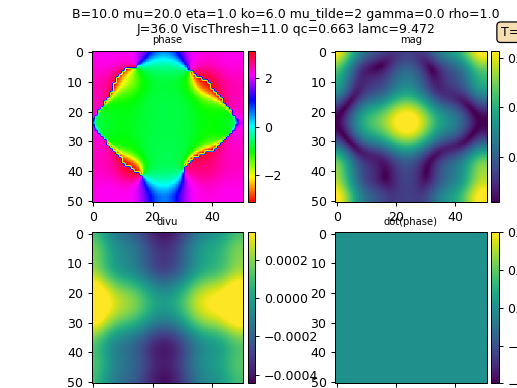

In [5]:

# visualise the data
title = ''
for item in params.items():
    title+=str(item[0])+'='+str(np.round(item[1],3))+' '
title+= '\n'
for item in qties.items():
    title+=str(item[0])+'='+str(np.round(item[1],3))+' '

    
data = np.asarray([shearphasedata,shearmagdata,divudata,abszdotdata])
subtitles = ['phase','mag','divu','dot(phase)']
cmaps = [plt.get_cmap('hsv'),plt.get_cmap('viridis'),plt.get_cmap('viridis'),plt.get_cmap('viridis')]


x=ContourPlotAnimator(data,times,subtitles,cmap=cmaps,title=title)
x.save('ani.mp4',fps=60)